# Baseball Batting Projections and Linear Regression Evaluation

### Written by Matthew Parra
Date: 7-13-2021

Twitter: @cursesincode

This notebook is used as a proof of concept for projecting a players batting statistics then using a Linear Regression to determain a players performance. This notebook will demonstrate my current understanding of not only baseball statistics and a players contribution to their team but also my growing knowledge of application development and the implementation of Machine Learning algorithms to help make insightful decisions. The resulting methods will be used to extend the MLB History Explorer. As this is the first of hopefully many research notebooks I will write on this topic, I decided to keep it simple and take a high level approach and attempt to predict some fundamental statistics that are key to evaluating a players batting performance and contribution to their team. The data that is used in this notebook is the same that has been used in my previous notebook, retrieved from Sean Lahman's website and formatted for use in my application.

In my research, it is clear there are many avenues one can take in predicting baseball statistics. The more advanced sZymborski Projection System (ZiPS) uses data from the previous four years for players from ages 24-38, and weights more recent seasons heavier. Steamer uses past performance and aging trends to develop a future projection for players. It also uses pitch-tracking data to help forecast pitchers. The simpler Marcel System uses only three seasons of data for a "minimum level of competence that you should expect from any forecaster". Whats considered the most accurate projection system is the ATC (Average Total Cost) projection system, which “averages” many projection systems together. The ATC System applies a different weight for each statistic for which it projects (weights are based on historical past performance).

If my projections fall somewhere within a reasonable range of any of the formentioned projection systems, I would deem my projections successful. With that said, I will omit the use of age adjustments and weighted statistics (wOBA, wRC/wRC+, WAR) as the point of this notebook is to study the evaluation of baseball statistics and apply a Linear Regression, not to recreate a system that already exits.

*Note: Although ZiPs and other systems may be mentioned in this notebook, the methods and any projections made here in are not meant to exactly match ZiPs or any other prediction system. ZiPs and any other system mentioned is only used as a means of comparison. I am NOT affiliated with any player, professional team, or sports analytic organizations (sports betting, evaluations, scouting, ect). Any projection created in this notebook should be treated as opinion.*

To begin our journey we must import Pandas and the Lahman Baseball data needed to evaluate players.

In [1]:
import pandas as pd
import numpy as np

In [2]:
batting_df = pd.read_csv('update_batting.csv')
pitching_df = pd.read_csv('update_pitching.csv')

### Data Prep

Since the data we are using is quite extensive and covers players as far back as the dead ball era and beyond, we will need to filter the data. For our purposes, we will be evaluating only the last 4 years of a players career. Certain statistics such as the Sacrifice Fly where not tracked until 1955 and the 162 game season did not begin until 1962. We also need to consider there have been many rule changes to the game since the 1962 season. Apart from All-Time greats such as Hank Aaron and Mickey Mantel supplying unprecidented statistics, there has also been an era of known performance enhancement that is sure to affect how we evaluate past statistics. Given all the considerations of MLB's history, I will be using player data from 2006 to 2020 to evaluate batting performance and contributions. Typically position players are evaluated for their batting skills as they are typically the primary producers of runs, therefore pitchers will be removed. Although there has been a number of times a player has reached beyond 162 games, I dropped those players seasons as we need to project players within a standard length season. Filtering our data using these factors will allow us to conduct some exploratory data analysis and help us find a clear path to understanding a players contribution but also their individual performance.

In [3]:
# Filter data to ensure we are only players from 2006 - 2020
batting_df = batting_df[(batting_df['year'] >= 2006) & (batting_df['year'] <= 2020)]

In [4]:
# Filter pitcher data the same as batting
pitching_df = pitching_df[(pitching_df['year'] >= 2006) & (pitching_df['year'] <= 2020)]

In [5]:
# Check for NA
batting_df.isna().sum()

player_id    0
year         0
stint        0
team_id      0
league_id    0
g            0
ab           0
r            0
h            0
double       0
triple       0
hr           0
rbi          0
sb           0
cs           0
bb           0
so           0
ibb          0
hbp          0
sh           0
sf           0
g_idp        0
dtype: int64

In [6]:
# Remove players that have more than 162 games played
batting_df.drop(batting_df[batting_df.g >= 163].index, inplace = True)

In [7]:
# Remove pitchers and return a dataframe of position players only
def remove_pitch(players, df):
    p_id = players
    for x in p_id:
        if x:
            df.drop(df[df.player_id == x].index, inplace = True)
        else:
            pass
    return df

In [8]:
# Create a list of Pithers ID's
pitcher_ids = pitching_df.player_id.unique()

In [9]:
# Apply the removal of pithers
batting_df = remove_pitch(pitcher_ids, batting_df)

In [10]:
# reset index so we may interate or slice through the dataframe without error
batting_df.reset_index(drop=True,inplace=True)

The 2020 season was shortened due to a pandemic, therefore we need to account for the fact that the maximum games a player could participate in was only 60. To compensate for the shortened season we can multiply the 2020 data by 2.7 (since 2.7*60 = 162). Here we have a function that can ingest the our current dataframe and multiply each column that matches the 2020 season by a factor of 2.7 resulting in an estimation of a full 162 game season. This estimation will be used in averaging a players performance over the past four years (2017 - 2020). This method treats all players and statistics in the dataset as equal. While this may negetively effect the accuracy of our projections in some areas, this step will aid in creating a more complete picture of a players performance thoughout the last four years and their career.

In [11]:
def year_factor(df):
    column_names = df.columns
    df_copy = df.copy()
    mask = df_copy['year'] == 2020
    for n, c in enumerate(column_names):
        if n <= 4:
            pass
        else:
            df_copy.loc[mask, c] = df_copy.loc[mask, c].apply(lambda x: round(x*2.7))
    return df_copy

In [12]:
batting_factor = year_factor(batting_df)

In [13]:
batting_factor[batting_factor.year == 2020]['g'].max()

162

We can see the max games for players in 2020 is 162. Now that our data is filtered and an adjustment is made for the short season, we can make some calculations that will aid our exploratory data analysis. Below are a set a functions that will calculate the statistics we will use to evaluate a players overall performance, as well as contribution to their team. To evaluate a batter we will look at their Plate Appearances, On-Base Percentage, Slugging average, On-Base Plus Slugging, and the players Runs Created. Most projection systems rely on the weighted Runs Creation of a player, which considers a weighted on-base percentage. Since we will not be considering weighted averages, we will instead perform the technical calculation along with the basic calculation and "stolen bases" version provided per FanGraphs (https://blogs.fangraphs.com/get-to-know-runs-created/).

In [14]:
# Calculate Estimate Plate Appearence
def calculate_pa(df):
    ab = df.ab
    bb = df.bb
    hbp = df.hbp
    sf = df.sf
    sh = df.sh
    return ab + bb + hbp + sf + sh


# Calculate On-Base Percentage
def calculate_obp(df):
    AB = df.ab
    Ht = df.h
    BB = df.bb
    HBP = df.hbp
    SF = df.sf
    try:
        return (Ht + BB + HBP) / (AB + BB + HBP + SF)
    except ZeroDivisionError :
        return 0


# Calculate Slugging Average
def calculate_slg(df):
    AB = df.ab
    Ht = df.h
    DBL = df.double
    TRP = df.triple
    HR = df.hr
    SNG = Ht - DBL - TRP - HR
    try:
        return (SNG + 2*DBL + 3*TRP + 4*HR)/AB
    except ZeroDivisionError :
        return 0

# Calculate OPS
def calculate_ops(df):
    slg = df.slg
    obp = df.obp
    return obp + slg


# Technical
# (H+BB-CS+HBP-GIDP)*(TB+(.26*(BB-IBB+HBP))+(.52*(SH+SF+SB)))/(AB+BB+HBP+SH+SF)
def calculate_trc(df):
    SNG = df.h - df.double - df.triple - df.hr
    DBL = 2 * df.double
    TPL = 3 * df.triple
    HR = 4 * df.hr
    TB = (SNG + DBL + TPL + HR)
    calc_1 = (df.h + df.bb - df.cs + df.hbp - df.g_idp) 
    calc_2 = .26 * (df.bb - df.ibb + df.hbp)
    calc_3 = .52 * (df.sh + df.sf + df.sb)
    calc_4 = (df.ab + df.bb + df.hbp + df.sh + df.sf)
    try:
        return (((calc_1)*((TB)+(calc_2)+(calc_3)))/(calc_4))
    except ZeroDivisionError :
        return 0


# Stolen Base
# (H+BB-CS)*(TB+(.55*SB))/(AB+BB)
def calculate_sbrc(df):
    SNG = df.h - df.double - df.triple - df.hr
    DBL = 2*df.double
    TPL = 3*df.triple
    HR = 4*df.hr
    TB = (SNG + DBL + TPL + HR)
    calc_1 = (df.h + df.bb - df.cs)
    calc_2 = .55 * df.sb
    calc_3 = df.ab + df.bb
    try:
        return (((calc_1) * ((TB) + (calc_2))) / calc_3)
    except ZeroDivisionError :
        return 0


# Basic
# (H+BB)*(TB)/(AB+BB)
def calculate_brc(df):
    SNG = df.h - df.double - df.triple - df.hr
    DBL = 2*df.double
    TPL = 3*df.triple
    HR = 4*df.hr
    TB = (SNG + DBL + TPL + HR)
    calc_1 = (df.h + df.bb)
    calc_2 = (df.ab + df.bb)
    try:
        return ((calc_1) * (TB) / (calc_2))
    except ZeroDivisionError :
        return 0

In [15]:
# Apply calculations and create new columns
batting_factor['pa'] = batting_factor.apply(calculate_pa,axis=1)
batting_factor['obp'] = round(batting_factor.apply(calculate_obp,axis=1),3)
batting_factor['slg'] = round(batting_factor.apply(calculate_slg,axis=1),3)
batting_factor['ops'] = round(batting_factor.apply(calculate_ops,axis=1),3)
batting_factor['t_rc'] = round(batting_factor.apply(calculate_trc,axis=1))
batting_factor['b_rc'] = round(batting_factor.apply(calculate_brc,axis=1))
batting_factor['s_rc'] = round(batting_factor.apply(calculate_sbrc,axis=1))

In [16]:
# set runs created columns to appropriate data type
batting_type = batting_factor.astype({"g":'int64', "ab":'int64', "r":'int64', "h":'int64', 
    "double":'int64', "triple":'int64', "hr":'int64', "rbi":'int64', "sb":'int64', "cs":'int64',
    "bb":'int64', "so":'int64', "ibb":'int64', "hbp":'int64', "sh":'int64', "pa":'int64',
    "sf":'int64', "g_idp":'int64', "t_rc":'int64', "b_rc":'int64', "s_rc":'int64'})

In [17]:
# Check data types
batting_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8717 entries, 0 to 8716
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player_id  8717 non-null   object 
 1   year       8717 non-null   int64  
 2   stint      8717 non-null   int64  
 3   team_id    8717 non-null   object 
 4   league_id  8717 non-null   object 
 5   g          8717 non-null   int64  
 6   ab         8717 non-null   int64  
 7   r          8717 non-null   int64  
 8   h          8717 non-null   int64  
 9   double     8717 non-null   int64  
 10  triple     8717 non-null   int64  
 11  hr         8717 non-null   int64  
 12  rbi        8717 non-null   int64  
 13  sb         8717 non-null   int64  
 14  cs         8717 non-null   int64  
 15  bb         8717 non-null   int64  
 16  so         8717 non-null   int64  
 17  ibb        8717 non-null   int64  
 18  hbp        8717 non-null   int64  
 19  sh         8717 non-null   int64  
 20  sf      

## Exploratory Data Analysis (EDA)

Now that our data is fully prepared, we can conduct some analysis. As I stated earlier we are trying to evaluate a players performance as well as their contribution. This includes creating projections for those players 2021 season. To begin we will look at how the number of games influences plate appearances (PA), just as plate appearances can affect a players on-base plus slugging (OPS). In turn I feel that if a player can successfully reach base, then he is more likely to contribute runs to the team. Runs win games, wins contribute to a teams ability to make the playoffs/win the World Series (not to oversimplify).

### Regression Analysis of Players (2006-2020)

So that we can visualize our data we will use Seaborn and MatPlotLib to help us visualize our evaluations. At a certain point we will be using a Liner Regression to evaluate a players performance. We conduct a regression analysis of all players in the past 14 years and see if our assertion is correct.

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_theme(style="whitegrid")
sns.set_context('notebook')

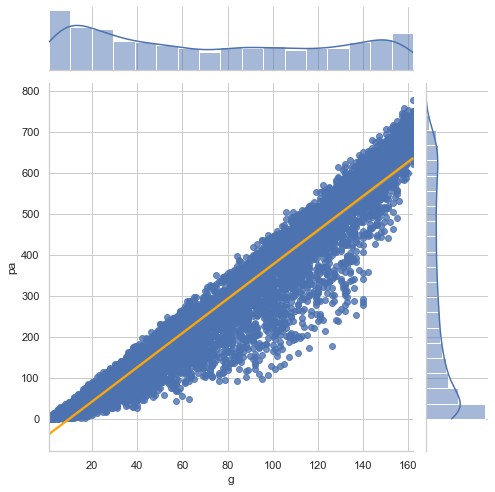

In [19]:
sns.jointplot(x='g',y='pa',data=batting_type,kind='reg',height=7,line_kws={'color': 'orange'})

Above we can see a strong correlation between Games played and Plate Appearances. As a player participates in a Game we can be sure they will acquire qualifying Plate Appearances.

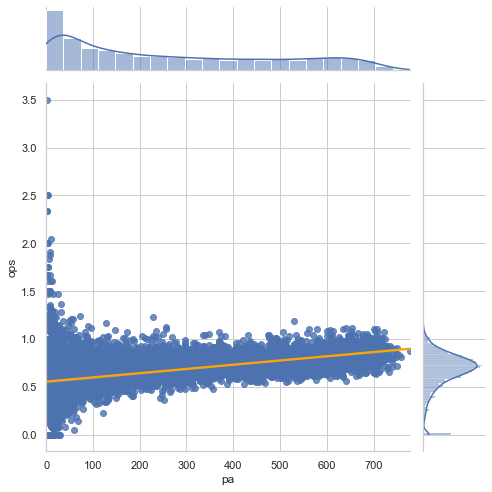

In [20]:
sns.jointplot(x='pa',y='ops',data=batting_type,kind='reg',height=7,line_kws={'color': 'orange'})

Looking at the graph above, Plate Appearances versus OPS (On-base Plus Slugging), it seems like there is only a strong correlation after 100 Plate Appearances. As a player has more qualifying Plate Appearances, it seems like we can expect an increase in that players OPS. Based on the OPS we can also assume a players OBP (On-Base Percentage) and SLG (Slugging) will increase as a player acquires more Plate Appearances.

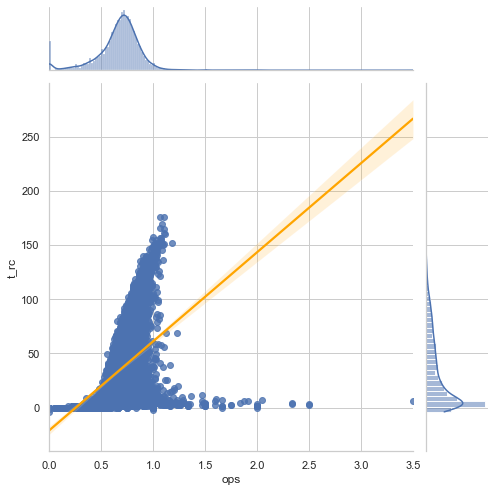

In [21]:
sns.jointplot(x='ops',y='t_rc',data=batting_type,kind='reg',height=7,line_kws={'color': 'orange'})

Although there is not a very strong correlation demonstrated above, we can see a notable increase in Runs Created as a players OPS increase between 0.500 and 1.000. I feel it is safe to say that if a player is unable to get on base (On-Base Percentage) or hit for power (Slugging Percentage) then we can be sure that player is not likely to create many if any runs.

### Runs Created and Team/Player Performance

Our current analysis supports the assertion that if a team where to have a high number of Plate Appearances resulting in an increase of On-Base Percentage and Slugging, that team would be capable of maximizing their Runs Created. A team increasing their Runs Created could translate into making the Playoffs and potentially winning the World Series. Although the point of this notebook is not to use Runs Created to predict a teams ability to make the playoffs, it seems to be a strong indicator. Below we look at the past 4 years (2017-2020) and explore how much Runs Created effects a teams ability to win a World Series much less make the Playoffs or obtain a Wild Card seat.

In [22]:
# Sum total of a team's runs created
# Aggregated from players with the same team_id
def team_rc_sum(df,yr):
    teams = df[df.year == yr].team_id.unique()
    team_rc = pd.DataFrame([], columns=['team','rc'])
    for z in teams:
        total_rc = df[(df.year == yr) & (df.team_id == z)].t_rc.sum()
        team_rc = team_rc.append({'team': z, 'rc': total_rc}, ignore_index=True)
    return team_rc

In [23]:
dodgers_team = team_rc_sum(batting_type,2020)

<AxesSubplot:xlabel='team'>

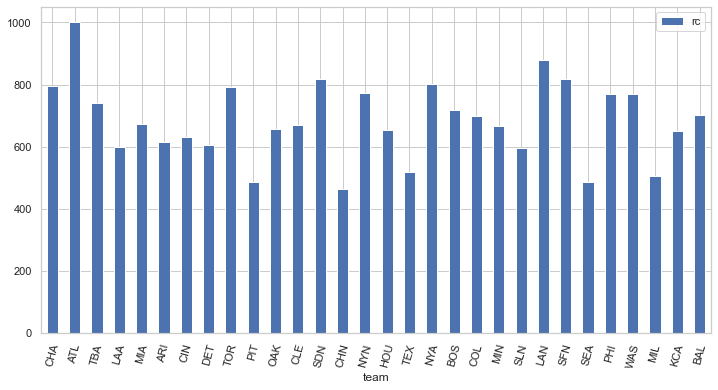

In [24]:
fig, ax = plt.subplots(figsize=(12,6))
dodgers_team.plot.bar(x='team',y='rc',rot=75, ax=ax)

In [25]:
# Runs created total for each team in 2020
dodgers_team[dodgers_team.rc >= 655].sort_values(by='rc',ascending=False)

,team,rc
1,ATL,1001
22,LAN,878
23,SFN,818
12,SDN,818
17,NYA,802
0,CHA,794
8,TOR,792
14,NYN,774
26,WAS,770
25,PHI,770


We can all admit that 2020 was quite unorthodox and yielded an unprecedented playoff landscape. There where 16 of the 30 MLB teams that made the Playoffs in 2020, of those teams, 8 played in their leagues Division and League Championship Series. Although the Los Angeles Dodgers won the World Series, they where 1 of only 5 that managed to create approximately 800+ runs. The team with the most Runs Created was the Atlanta Braves (1001), they lost to the Dodgers in the NLCS (National League Championship Series) 4 games to 3.

In [26]:
nationals_team = team_rc_sum(batting_type,2019)

<AxesSubplot:xlabel='team'>

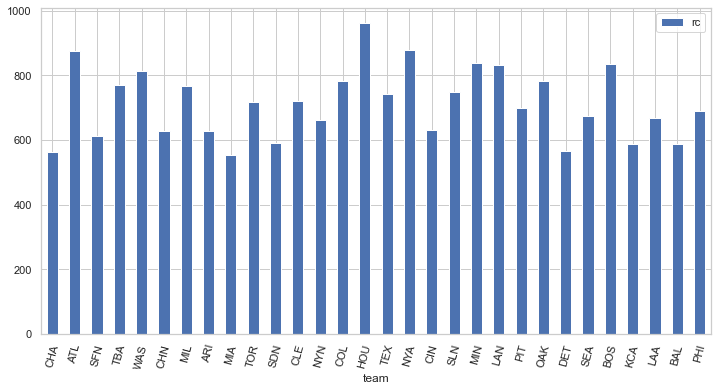

In [27]:
fig, ax = plt.subplots(figsize=(12,6))
nationals_team.plot.bar(x='team',y='rc',rot=75, ax=ax)

In [28]:
# Runs created total for each team in 2019
nationals_team[nationals_team.rc >= 749].sort_values(by='rc',ascending=False)

,team,rc
14,HOU,962
16,NYA,880
1,ATL,875
19,MIN,839
25,BOS,836
20,LAN,834
4,WAS,815
22,OAK,783
13,COL,782
3,TBA,770


The 2019 season was historic for the Washington Nationals as it was their first World Series win in franchise history. Although the Houston Astros did not win, they managed to post the most Runs Created in the regular season (962). The Nationals created only 815 runs in the regular season and was awarded a Wild Card seat after a 93 win season. The 2018 playoffs hosted only four other teams that managed to create 800+ runs. The Boston Red Sox did not make the playoffs in spite of their 836 Runs Created in the regular season.

In [29]:
Boston_team = team_rc_sum(batting_type,2018)

<AxesSubplot:xlabel='team'>

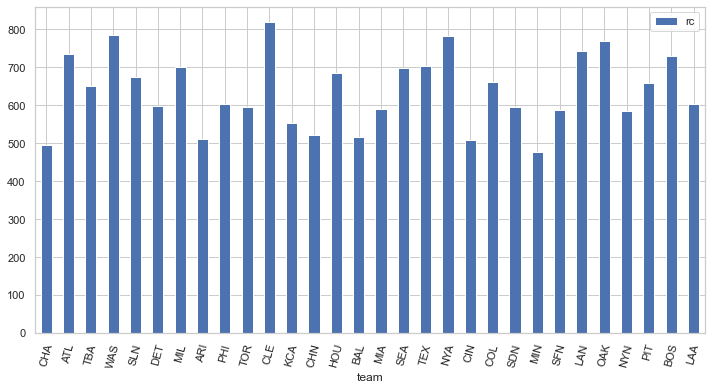

In [30]:
fig, ax = plt.subplots(figsize=(12,6))
Boston_team.plot.bar(x='team',y='rc',rot=75, ax=ax)

In [31]:
# Runs created total for each team in 2018
Boston_team[Boston_team.rc >= 686].sort_values(by='rc',ascending=False)

,team,rc
10,CLE,819
3,WAS,786
18,NYA,783
25,OAK,769
24,LAN,744
1,ATL,735
28,BOS,729
17,TEX,704
6,MIL,701
16,SEA,697


The 2018 season was a little underwhelming in terms of Runs Created compared to the previous two seasons. The Boston Red Sox only managed 729 Runs Created in the regular season and still won the World Series. Although the Cleveland Indians had the highest Runs Created (819), they could not push past the Division Series losing to the Houston Astros.

In [32]:
houston_team = team_rc_sum(batting_type,2017)

<AxesSubplot:xlabel='team'>

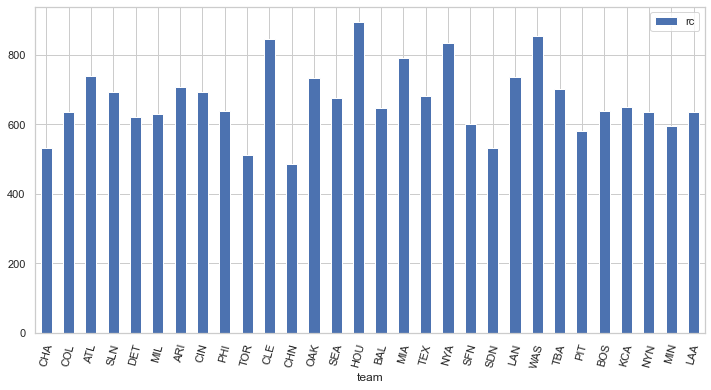

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
houston_team.plot.bar(x='team',y='rc',rot=75, ax=ax)

In [34]:
# Runs created total for each team in 2017
houston_team[houston_team.rc >= 708].sort_values(by='rc',ascending=False)

,team,rc
14,HOU,893
22,WAS,854
10,CLE,844
18,NYA,833
16,MIA,791
2,ATL,738
21,LAN,735
12,OAK,733
6,ARI,708


Finally, the 2017 season saw four teams reaching well above 800 Runs Created in the regular season all making the playoffs. The Houston Astros not only won the World Series, but also posted the highest Runs Created for the season (893). The Astros World Series opponents (Los Angeles Dodgers) only had 735 Runs Created. Studying regular season Runs Created for each of the past four seasons reveals that a team can certainly make it to the playoffs, although winning any post season game much less a World Series title requires more than a productive season. To dig further into Runs Created as a metric of team success, lets take a look at how each position player for the 2017 Houston Astros contributed.

In [35]:
# select the 2017 Houston Astros
houston_data = batting_type[(batting_type.year == 2017)&(batting_type.team_id == 'HOU')]

In [36]:
print('Total RC:',houston_data.t_rc.sum())

Total RC: 893


<AxesSubplot:xlabel='player_id'>

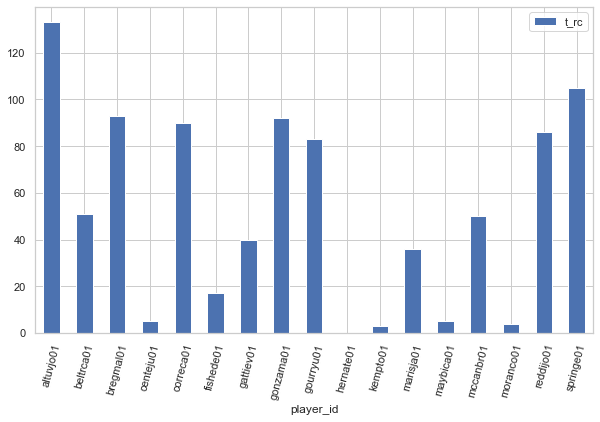

In [37]:
fig, ax = plt.subplots(figsize=(10,6))
houston_data.plot.bar(x='player_id',y='t_rc',rot=75, ax=ax)

Looking at the break down of players from the 2017 Houston Astros we can see Jose Altuve was certainly an All-Star with 133 Runs Created and George Springer posting over 100 Runs Created. Additionally the Astros had 5 other players reach well over 80 Runs Created. We can see that players who can contribute to Runs Created aid in the overall success of that team.

## Player Estimations
### Games and At-Bats

Now that we have spent some time looking at how players can contribute to their team. We need to consider how we can attempt to predict a players batting performance. Our dataset already comes with a set of statistics that we can use to make calculations and help us understand a players performance. It would be an overkill for us to use any kind of regression algorithm to make these predictions as we have everything we need at our finger tips. For our projections (predictions) we will average each statistic needed to make our calculations while using certain statistics (Games, At-Bats, Hits) to supply a weight (the more significant a season the heavier the weight). Lets consider Alex Bregman whom has been a consistent contributor to the success of the Huston Astros, in spite of injuries.

First we need to create a projection for a players Games played, if a player doesn't appear in a Game he can not contribute. We will use Bregman's past four seasons to help us make projections for his 2021 season.

In [38]:
# Selecting Alex Bregman and his last four seasons
breg_batting = batting_type[(batting_type.year >= 2017)&(batting_type.year <= 2020)&
    (batting_type.player_id == 'bregmal01')]

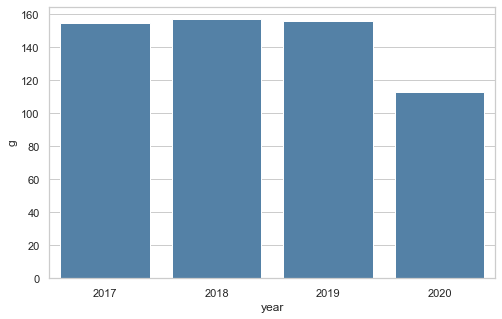

In [39]:
# List games totals for the last four season of Alex Bregman
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.barplot(x='year',y='g',data=breg_batting, color='steelblue')
plt.show(fig)

The 2020 season has already been accounted for earlier in this notebook and applied to our dataset. We can see that Bregman has played very consistently from 2017 to 2019. The estimated 2020 full season for Bregman was affected by the fact that he missed 17 games during the short season after straining his right hamstring. Continuing with our projection we will average Games played using the same as a weight. I decided that past seasons might be a better representation of a players Games played, although this and any of our other projections assumes that all players are equal with respect to our 2020 season estimation.

In [40]:
# Calculate Games played using 4 season sample, using each season's game total as 
# a weight (Larger the total, heavier the weight)
breg_proj_games = round(np.average(breg_batting['g'], weights=breg_batting['g']))

In [41]:
print('Alex Bregman - Projected Games: ', breg_proj_games)

Alex Bregman - Projected Games:  148


We project that Bregman might have 148 games in the 2021 regular season. Now we can continue our projections by creating an At-Bats per Game rate that will help us create an average that we can use for our projection.

In [42]:
# Calculate the average At-Bats per Game played in a season
def rate(df):
    return df.ab / df.g

In [43]:
# Filter data once again to show ab/g rate for Alex Bregman from 2017 - 2020
breg_ab_data = breg_batting.copy()

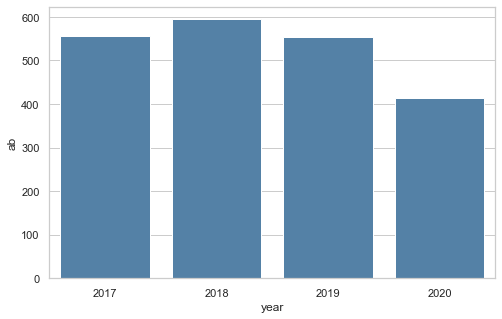

In [44]:
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.barplot(x='year',y='ab',data=breg_batting, color='steelblue')
plt.show(fig)

In [45]:
# Apply the ab/g rate to a new column
breg_ab_data['rate'] = breg_ab_data.apply(rate,axis=1)

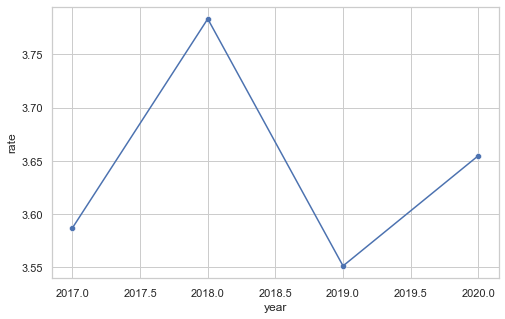

In [46]:
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.scatterplot(x="year", y="rate",data=breg_ab_data)
sns.lineplot(x="year", y="rate",data=breg_ab_data)
plt.show(fig)

Looking at Bregman's At-Bats per year as well as At-Bats per Game we can see a trend developing. Bregman might average the same At-Bats per Game rate, his At-Bats total is sure to be higher than the 2020 estimation.

In [47]:
breg_ab_rate = np.average(breg_ab_data['rate'], weights=breg_ab_data['g'])

In [48]:
# Calculate projected At-Bats by multiplying the projected number of Games by the projected AB Rate
breg_proj_ab = round(breg_proj_games * breg_ab_rate)

In [49]:
print('Alex Bregman - 2021 Projection')
print('AB/G:', round(breg_ab_rate,2))
print('AB:', breg_proj_ab)

Alex Bregman - 2021 Projection
AB/G: 3.64
AB: 539


### Plate Apperences

With Games and At-Bats projected we can begin to explore Plate Appearances. First we need to look at the factors that make up the Plate Appearance statistic and then project each so that we can calculate Bregmans 2021 projected Plate Appearances.

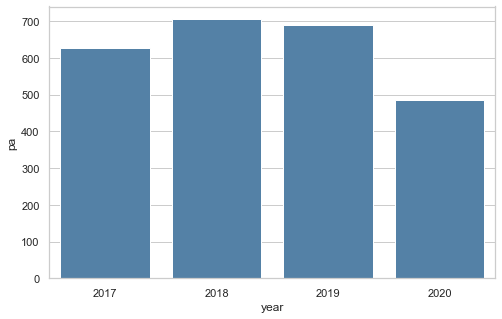

In [50]:
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.barplot(x='year',y='pa',data=breg_batting, color='steelblue')
plt.show(fig)

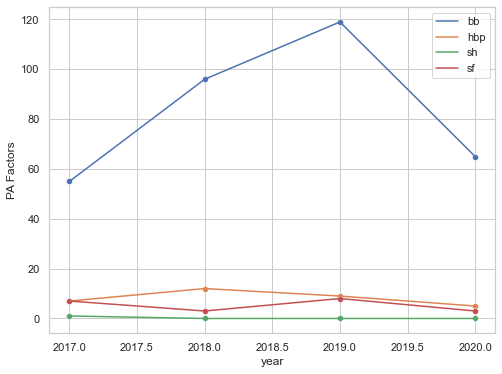

In [51]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sns.scatterplot(x="year", y="bb",data=breg_batting)
sns.lineplot(x="year", y="bb",data=breg_batting)
sns.scatterplot(x="year", y="hbp",data=breg_batting)
sns.lineplot(x="year", y="hbp",data=breg_batting)
sns.scatterplot(x="year", y="sh",data=breg_batting)
sns.lineplot(x="year", y="sh",data=breg_batting)
sns.scatterplot(x="year", y="sf",data=breg_batting)
sns.lineplot(x="year", y="sf",data=breg_batting)
ax.legend(['bb','hbp','sh','sf'])
plt.xlabel("year")
plt.ylabel("PA Factors")
plt.show(fig)

Analyzing Alex Bregman's Plate Appearances and the factors (Walks, Hit-By-Pitch, Sacrifice Hits, Sacrifice Flys) we can see he began to draw more walks in 2019 showing great patience at the plate. Like Games we can average each factor but use At-Bats for weights, as a player can not draw a walk or get hit by a pitch if they do not take an At-Bat. Then we can add each factor together to create a Plate Appearance projection for Alex Bregman.

In [52]:
# average plate appearances and use at-bats as a weight
breg_bb = round(np.average(breg_ab_data['bb'], weights=breg_ab_data['ab']))
breg_hbp = round(np.average(breg_ab_data['hbp'], weights=breg_ab_data['ab']))
breg_sh = round(np.average(breg_ab_data['sh'], weights=breg_ab_data['ab']))
breg_sf = round(np.average(breg_ab_data['sf'], weights=breg_ab_data['ab']))

In [53]:
# Estimate Alex Bregman Plate Apperences - 2021
breg_proj_pa = breg_proj_ab + breg_bb + breg_hbp + breg_sh + breg_sf

In [54]:
# Filter data to isolate Alex Bregman from 2017 to 2020 (4 season sample)
breg_batting.drop(['stint','r','double','triple','hr','rbi','sb','cs','so','ibb','g_idp',
                        'obp','slg','ops','t_rc','b_rc','s_rc'],axis=1)

,player_id,year,team_id,league_id,g,ab,h,bb,hbp,sh,sf,pa
6552,bregmal01,2017,HOU,AL,155,556,158,55,7,1,7,626
7106,bregmal01,2018,HOU,AL,157,594,170,96,12,0,3,705
7670,bregmal01,2019,HOU,AL,156,554,164,119,9,0,8,690
8243,bregmal01,2020,HOU,AL,113,413,100,65,5,0,3,486


In [55]:
print('Alex Bregman - 2021 Projection')
print('Games:', breg_proj_games)
print('At-Bats:', breg_proj_ab)
print('AB/G: {:.2f}'.format(breg_ab_rate))
print('Walks:', breg_bb)
print('Hit-By-Pitch:', breg_hbp)
print('Sac-Hits:', breg_sh)
print('Sac-Flys:', breg_sf)
print('Plate Apperences:', breg_proj_pa)

Alex Bregman - 2021 Projection
Games: 148
At-Bats: 539
AB/G: 3.64
Walks: 85
Hit-By-Pitch: 9
Sac-Hits: 0
Sac-Flys: 5
Plate Apperences: 638


Comparing our projection of Bregman to his past seasons, we can see he has the potential to remain on par in spite of the 2020 season.

### On-Base Percentage

Next we need to consider Bregman's batting performance. To measure his performance as well as any other player we can take a look at On-Base Percentage as well as Slugging. To create a complete picture of Bregman's performance we can also project his OPS (On-Base Plus Slugging).

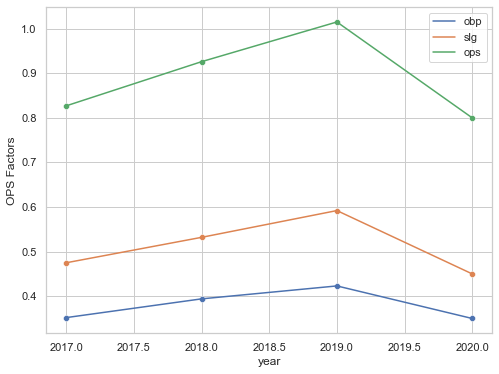

In [56]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sns.lineplot(x="year",y="obp",data=breg_batting)
sns.scatterplot(x="year",y="obp",data=breg_batting)
sns.lineplot(x="year", y="slg",data=breg_batting)
sns.scatterplot(x="year", y="slg",data=breg_batting)
sns.lineplot(x="year", y="ops",data=breg_batting)
sns.scatterplot(x="year", y="ops",data=breg_batting)
ax.legend(['obp','slg','ops'])
plt.xlabel("year")
plt.ylabel("OPS Factors")
plt.show(fig)

We can see that Bregman was on a significant up trend from 2017 to 2019, indicating that he may be capable of providing a notable performance for his 2021 season. To create a projection of each statistical average (OBP, SLG, OPS) we will need to include a projection for Hits, then we can calculate Bregman's On-Base Percentage (OBP). We will use At-Bat's as a weight, a player can't get a hit if he does not take an At-Bat.

In [57]:
# Calculate a players on-base percentage
def calculate__player_obp(AB,HT,BB,HBP,SF):
    try:
        return (HT + BB + HBP) / (AB + BB + HBP + SF)
    except ZeroDivisionError :
        return 0

In [58]:
# Average hits using at-bats as a weight
breg_h = round(np.average(breg_batting['h'], weights=breg_batting['ab']))

In [59]:
breg_proj_obp = calculate__player_obp(breg_proj_ab,breg_h,breg_bb,breg_hbp,breg_sf)

### Slugging Average

Continuing our projection of Alex Bregman's batting performance for 2021 we need to include a projection for Doubles, Triples, and Home Runs. Once we have the factors we need we can calculate the potential Slugging (SLG) of Bregman for 2021.

In [60]:
# Calculate Slugging Average
def calculate_player_slg(AB,HT,DBL,TRP,HR):
    SNG = HT - DBL - TRP - HR
    try:
        return (SNG + 2*DBL + 3*TRP + 4*HR)/AB
    except ZeroDivisionError :
        return 0

In [61]:
# average doubles, triples, and home runs with hits as weights
breg_dbl = round(np.average(breg_batting['double'], weights=breg_batting['h']))
breg_trp = round(np.average(breg_batting['triple'], weights=breg_batting['h']))
breg_hr = round(np.average(breg_batting['hr'], weights=breg_batting['h']))

In [62]:
breg_proj_slg = calculate_player_slg(breg_proj_ab, breg_h, breg_dbl, breg_trp, breg_hr)

### On-Base Plus Slugging

Now that we have created On-Base Percentage (OBP) and Slugging (SLG) projections for Bregman we can simply add them together to create the On-Base Plus Slugging (OPS) projection for his 2021 season.

In [63]:
breg_proj_ops = breg_proj_obp + breg_proj_slg

In [64]:
breg_batting.drop(['stint','r','double','triple','hr','rbi','sb','cs','so','ibb','g_idp','t_rc','b_rc','s_rc','bb','hbp','sh','sf'],axis=1)

,player_id,year,team_id,league_id,g,ab,h,pa,obp,slg,ops
6552,bregmal01,2017,HOU,AL,155,556,158,626,0.352,0.475,0.827
7106,bregmal01,2018,HOU,AL,157,594,170,705,0.394,0.532,0.926
7670,bregmal01,2019,HOU,AL,156,554,164,690,0.423,0.592,1.015
8243,bregmal01,2020,HOU,AL,113,413,100,486,0.350,0.450,0.800


In [65]:
print('Bregman - 2021 Projection')
print('Games:', breg_proj_games)
print('AB:', breg_proj_ab)
print('PA:', breg_proj_pa)
print('H:', breg_h)
print('OBP:', round(breg_proj_obp,3))
print('SLG:', round(breg_proj_slg,3))
print('OPS:', round(breg_proj_ops,3))

Bregman - 2021 Projection
Games: 148
AB: 539
PA: 638
H: 152
OBP: 0.386
SLG: 0.525
OPS: 0.911


At this point we have created projections for Alex Bregman's batting performance for the 2021 season. It seems as though he has the potential to have a rock solid season.

### Runs Created

We have a clear path to projecting a players statistics that reflect there batting performance, we now need to consider how that translates into contributing to a team's Runs Created. Lets consider Alex Bregman's Runs Created (Basic, Stolen Base, Technical).

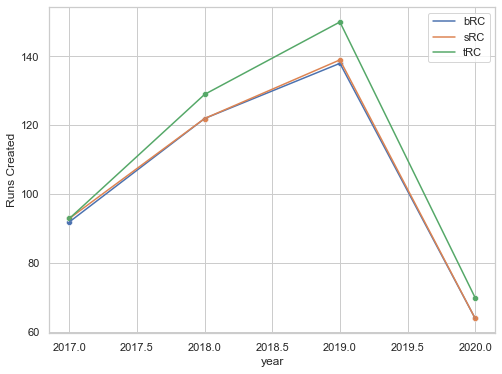

In [66]:
fig, ax = plt.subplots(figsize=(8,6))
fig = sns.lineplot(x="year", y="b_rc",data=breg_batting)
sns.scatterplot(x="year", y="b_rc",data=breg_batting)
sns.lineplot(x="year", y="s_rc",data=breg_batting)
sns.scatterplot(x="year", y="s_rc",data=breg_batting)
sns.lineplot(x="year", y="t_rc",data=breg_batting)
sns.scatterplot(x="year", y="t_rc",data=breg_batting)
ax.legend(['bRC','sRC','tRC'])
plt.xlabel("year")
plt.ylabel("Runs Created")
plt.show(fig)

We can see, like Bregman's OPS, his Runs Created was on a significant up trend prior to the 2020 season. In order to project a players Runs Created (Basic, Stolen Base, Technical) we need to include projections for Intentional Walks (IBB), Stolen Bases (SB), Caught Stealing (CS), and Grounded Into Double Plays (GIDP). Each of the new projections will use either At-Bats or Hits as a weight factor.

In [67]:
# Technical
# (H+BB-CS+HBP-GIDP)*(TB+(.26*(BB-IBB+HBP))+(.52*(SH+SF+SB)))/(AB+BB+HBP+SH+SF)
def calculate_player_trc(AB,H,DBL,TRP,HR,IBB,BB,HBP,SF,SH,SB,CS,GIDP):
    SNG = H - DBL - TRP - HR
    DB = 2 * DBL
    TP = 3 * TRP
    Hr = 4 * HR
    TB = (SNG + DB + TP + Hr)
    calc_1 = (H + BB - CS + HBP - GIDP) 
    calc_2 = .26 * (BB - IBB + HBP)
    calc_3 = .52 * (SH + SF + SB)
    calc_4 = (AB + BB + HBP + SH + SF)
    try:
        return (((calc_1)*((TB)+(calc_2)+(calc_3)))/(calc_4))
    except ZeroDivisionError :
        return 0


# Stolen Base
# (H+BB-CS)*(TB+(.55*SB))/(AB+BB)
def calculate_player_sbrc(AB,H,DBL,TRP,HR,BB,SB,CS):
    SNG = H - DBL - TRP - HR
    DB = 2*DBL
    TP = 3*TRP
    Hr = 4*HR
    TB = (SNG + DB + TP + Hr)
    calc_1 = (H + BB - CS)
    calc_2 = .55 * SB
    calc_3 = AB + BB
    try:
        return (((calc_1) * ((TB) + (calc_2))) / calc_3)
    except ZeroDivisionError :
        return 0

# Basic
def calculate_player_brc(AB,H,DBL,TRP,HR,BB):
    SNG = H - DBL - TRP - HR
    DB = 2*DBL
    TP = 3*TRP
    Hr = 4*HR
    TB = (SNG + DB + TP + Hr)
    calc_1 = (H + BB)
    calc_2 = (AB + BB)
    try:
        return ((calc_1) * (TB) / (calc_2))
    except ZeroDivisionError :
        return 0

In [68]:
# average intentional walks, stolen base, caught stealing, and grounded into double plays
# use at-bats and hits as weights
breg_ibb = round(np.average(breg_batting['ibb'], weights=breg_batting['ab']))
breg_sb = round(np.average(breg_batting['sb'], weights=breg_batting['h']))
breg_cs = round(np.average(breg_batting['cs'], weights=breg_batting['h']))
breg_gidp = round(np.average(breg_batting['g_idp'], weights=breg_batting['ab']))

In [69]:
breg_proj_brc = calculate_player_brc(breg_proj_ab, breg_h, breg_dbl, breg_trp, breg_hr, breg_bb)
breg_proj_sbrc = calculate_player_sbrc(breg_proj_ab, breg_h, breg_dbl, breg_trp, breg_hr, breg_bb,
    breg_sb, breg_cs)
breg_proj_trc = calculate_player_trc(breg_proj_ab, breg_h, breg_dbl, breg_trp, breg_hr, breg_ibb, 
    breg_bb, breg_hbp, breg_sf, breg_sh, breg_sb, breg_cs, breg_gidp)

In [70]:
print('Basic Runs Created:', round(breg_proj_brc))
print('Stolen Base Runs Created:', round(breg_proj_sbrc))
print('Technical Runs Created:', round(breg_proj_trc))

Basic Runs Created: 107
Stolen Base Runs Created: 108
Technical Runs Created: 114


Based on his past four seasons, Bregman has the potential of providing over 100 Runs Created in the 2021 season.

## Linear Regression

Now that we have created a number of projections, we need to also consider the players performance over time. In order to evaluate a players performance throughout their career as well as the past four seasons we can use a Linear Regression. Over time a players statistics will fluctuate based on their performance, we can take the desired amount of time and fit the players statistics to a Linear Regression and observe the coefficient which will indicate the direction of performance. If a player is performing well in a given statistic the Linear Regression will return a positive coefficient otherwise it will return a negative coefficient.

In [71]:
from sklearn.linear_model import LinearRegression

In [72]:
X = breg_batting['year'].values.reshape(-1,1)
y = breg_batting['ops'].values.reshape(-1,1)

In [73]:
player_pa_reg = LinearRegression().fit(X,y)

In [74]:
player_coef = player_pa_reg.coef_

In [76]:
if round(player_coef[0][0],3) < 0:
    print('Down:', round(player_coef[0][0] * 1000,2))
elif round(player_coef[0][0] * 1000,2) == 0:
    # if 0 to the 1,000 place no change
    print('NC')
else:
    print('Up:', round(player_coef[0][0] * 1000,2))

Up: 0.8


The coefficient returned will have the same unit size as the variable evaluated. Certain statistics such as OPS will be multiplied by 1000 to make the unit of change readable in a graph. For Alex Bregman, we can see the coefficient of his OPS is not very significant indicating little to no change in the direction of his OPS. In other words, Bregman has demonstrated no significant improvement or decline in his OPS performance.

## Projection Fucntion

In this notebook, we have created many projections for Alex Bregman. The method developed can also be applied to other position players whom we want to evaluate. Below, I have pulled together all the necessary support functions that will aid in projecting a player's future season. The function will take in a dataframe that has been filtered for time (Year range) and has the 2020 season estimated as a full season, if you are projecting the 2021 season, and the desired player. In this function we have also included a projection for runs, although this particular statistic is not used in any calculation we need this statistic so that we do not produce an NA column when comparing to past seasons. Additionally we also included a means to combine players stints into one year, as players may be traded mid season and have multiple stints within one season.

In [77]:
def player_project(data, player):
    
    # Calculate the average At-Bats per Game played in a season
    def ab_rate(df):
        return df.ab / df.g
    
    # Calculate Estimate Plate Appearence
    def calc_pa(df):
        ab = df.ab
        bb = df.bb
        hbp = df.hbp
        sf = df.sf
        sh = df.sh
        return ab + bb + hbp + sf + sh

    # Calculate On-Base Percentage
    def calc_obp(df):
        AB = df.ab
        Ht = df.h
        BB = df.bb
        HBP = df.hbp
        SF = df.sf
        try:
            return (Ht + BB + HBP) / (AB + BB + HBP + SF)
        except ZeroDivisionError :
            return 0

    # Calculate Slugging Average
    def calc_slg(df):
        AB = df.ab
        Ht = df.h
        DBL = df.double
        TRP = df.triple
        HR = df.hr
        SNG = Ht - DBL - TRP - HR
        try:
            return (SNG + 2*DBL + 3*TRP + 4*HR)/AB
        except ZeroDivisionError :
            return 0

    # Calculate OPS
    def calc_ops(df):
        slg = df.slg
        obp = df.obp
        return obp + slg

    # Basic
    # (H+BB)*(TB)/(AB+BB)
    def calc_brc(df):
        SNG = df.h - df.double - df.triple - df.hr
        DBL = 2*df.double
        TPL = 3*df.triple
        HR = 4*df.hr
        TB = (SNG + DBL + TPL + HR)
        calc_1 = (df.h + df.bb)
        calc_2 = (df.ab + df.bb)
        try:
            return ((calc_1) * (TB) / (calc_2))
        except ZeroDivisionError :
            return 0

    # Stolen Base
    # (H+BB-CS)*(TB+(.55*SB))/(AB+BB)
    def calc_sbrc(df):
        SNG = df.h - df.double - df.triple - df.hr
        DBL = 2*df.double
        TPL = 3*df.triple
        HR = 4*df.hr
        TB = (SNG + DBL + TPL + HR)
        calc_1 = (df.h + df.bb - df.cs)
        calc_2 = .55 * df.sb
        calc_3 = df.ab + df.bb
        try:
            return (((calc_1) * ((TB) + (calc_2))) / calc_3)
        except ZeroDivisionError :
            return 0
    
    # https://en.wikipedia.org/wiki/Runs_created
    # Technical
    # (H+BB-CS+HBP-GIDP)*(TB+(.26*(BB-IBB+HBP))+(.52*(SH+SF+SB)))/(AB+BB+HBP+SH+SF)
    def calc_trc(df):
        SNG = df.h - df.double - df.triple - df.hr
        DBL = 2 * df.double
        TPL = 3 * df.triple
        HR = 4 * df.hr
        TB = (SNG + DBL + TPL + HR)
        calc_1 = (df.h + df.bb - df.cs + df.hbp - df.g_idp) 
        calc_2 = .26 * (df.bb - df.ibb + df.hbp)
        calc_3 = .52 * (df.sh + df.sf + df.sb)
        calc_4 = (df.ab + df.bb + df.hbp + df.sh + df.sf)
        try:
            return (((calc_1)*((TB)+(calc_2)+(calc_3)))/(calc_4))
        except ZeroDivisionError :
            return 0


    player_data = data[data.player_id == player]

    player_data = player_data.groupby(['year']).sum().reset_index()
    
    proj_games = round(np.average(player_data['g'], weights=player_data['g']))

    player_data['rate'] = player_data.apply(ab_rate,axis=1)
    player_ab_rate = np.average(player_data['rate'], weights=player_data['g'])
    proj_ab = round(proj_games * player_ab_rate)

    proj_r = round(np.average(player_data['r'], weights=player_data['ab']))
    proj_h = round(np.average(player_data['h'], weights=player_data['ab']))
    proj_dbl = round(np.average(player_data['double'], weights=player_data['h']))
    proj_trp = round(np.average(player_data['triple'], weights=player_data['h']))
    proj_hr = round(np.average(player_data['hr'], weights=player_data['h']))
    proj_rbi = round(np.average(player_data['rbi'], weights=player_data['ab']))
    proj_sb = round(np.average(player_data['sb'], weights=player_data['h']))
    proj_cs = round(np.average(player_data['cs'], weights=player_data['h']))
    proj_bb = round(np.average(player_data['bb'], weights=player_data['ab']))
    proj_so = round(np.average(player_data['so'], weights=player_data['ab']))
    proj_ibb = round(np.average(player_data['ibb'], weights=player_data['ab']))
    proj_hbp = round(np.average(player_data['hbp'], weights=player_data['ab']))
    proj_sh = round(np.average(player_data['sh'], weights=player_data['ab']))
    proj_sf = round(np.average(player_data['sf'], weights=player_data['ab']))
    proj_gidp = round(np.average(player_data['g_idp'], weights=player_data['ab']))

    predictions = np.array([[player, 2021, 1, 'PROJ', '--', proj_games, proj_ab, proj_r, proj_h, 
        proj_dbl, proj_trp, proj_hr, proj_rbi, proj_sb, proj_cs, proj_bb, proj_so, proj_ibb, 
        proj_hbp, proj_sh, proj_sf, proj_gidp]], dtype=object)
    
    pred_col = data.columns

    player_projection = pd.DataFrame(predictions, columns=pred_col)

    player_projection['pa'] = player_projection.apply(calc_pa,axis=1)
    player_projection['obp'] = round(player_projection.apply(calc_obp,axis=1),3)
    player_projection['slg'] = round(player_projection.apply(calc_slg,axis=1),3)
    player_projection['ops'] = round(player_projection.apply(calc_ops,axis=1),3)
    player_projection['t_rc'] = round(player_projection.apply(calc_trc,axis=1))
    player_projection['b_rc'] = round(player_projection.apply(calc_brc,axis=1))
    player_projection['s_rc'] = round(player_projection.apply(calc_sbrc,axis=1))

    player_projection = player_projection.astype({"year":'int64',"stint":'int64',"g":'int64', 
        "ab":'int64', "ab":'int64', "h":'int64', "r":'int64', "double":'int64',"triple":'int64', 
        "hr":'int64', "rbi":'int64', "sb":'int64', "cs":'int64',"bb":'int64', "so":'int64', 
        "ibb":'int64',"hbp":'int64',"sh":'int64', "pa":'int64', "sf":'int64', "g_idp":'int64', 
        "t_rc":'int64',"b_rc":'int64',"s_rc":'int64'})
    
    return player_projection

With this function we can now take the steps that would be used in an application to project (estimate) a players 2021 season. First creating a clean dataset (only statistics that are provided by Lahman's Baseball Database), then slicing out the past four years (2017 to 2020), factoring in an estimation of a full 2020 season (using a global function), and then creating our projection.

In [78]:
clean_data = pd.read_csv('update_batting.csv')

In [79]:
four_season_sample = clean_data[(clean_data.year >= 2017) & (clean_data.year <= 2020)]

In [80]:
four_season_sample.reset_index(drop=True,inplace=True)

In [81]:
data_factor = year_factor(four_season_sample)

In [82]:
breg_fun_pred = player_project(data_factor, 'bregmal01')

In [83]:
breg_fun_pred

,player_id,year,stint,team_id,league_id,g,ab,r,h,double,...,sh,sf,g_idp,pa,obp,slg,ops,t_rc,b_rc,s_rc
0,bregmal01,2021,1,PROJ,--,148,539,94,152,41,...,0,5,11,638,0.386,0.525,0.911,114,107,108


In [84]:
print('Alex Bregman - 2021 Projection')
print('Games:', breg_fun_pred.g[0])
print('At-Bats:', breg_fun_pred.ab[0])
print('PA:', breg_fun_pred.pa[0])
print('OBP:', breg_fun_pred.obp[0])
print('SLG:', breg_fun_pred.slg[0])
print('OPS:', breg_fun_pred.ops[0])
print('tRC:', breg_fun_pred.t_rc[0])
print('bRCa:', round((breg_fun_pred.b_rc[0] / 27),2))

Alex Bregman - 2021 Projection
Games: 148
At-Bats: 539
PA: 638
OBP: 0.386
SLG: 0.525
OPS: 0.911
tRC: 114
bRCa: 3.96


We can see the projections created for Alex Bregman match the projections we created earlier. We have also used the Basic Runs Created to display a simple Runs Created Average (the averaged number of Runs Created over a 9 inning period or 27 outs). Next we can use the coefficient concept demonstrated earlier to provide an evaluation of that players performance. Similar to our projection function, the Linear Regression evaluation function will take in a dataframe and desired player and provide coefficients for each statistic.

In [85]:
def player_lr_eval(df,player):

    def player_lrce(df,c):
        X = df.year.values.reshape(-1,1)
        y = df[c].values.reshape(-1,1)
        player_reg = LinearRegression().fit(X,y)
        if c == 'obp':
            return_value = player_reg.coef_
            return return_value[0][0] * 1000
        if c == 'slg':
            return_value = player_reg.coef_
            return return_value[0][0] * 1000
        if c == 'ops':
            return_value = player_reg.coef_
            return return_value[0][0] * 1000
        else:
            return_value = player_reg.coef_
            return return_value[0][0]
    
    column_names = df.columns

    df_copy = df.copy()
    df_copy = df_copy.groupby(['year']).sum().reset_index()
    
    data = [player,2021,1,'EVAL','--']
    
    for n, c in enumerate(column_names):
        if n <= 4:
            pass
        else:
            value = player_lrce(df_copy,c)
            data.append(value)

    df_copy['player_id'] = player
    df_copy['team_id'] = df.team_id
    df_copy['league_id'] = df.league_id
    
    # shift column 'Name' to first position
    first_col = df_copy.pop('player_id')
    fourth_col = df_copy.pop('team_id')
    fifth_col = df_copy.pop('league_id')
    
    # insert column using insert(position,column_name,
    # first_column) function
    df_copy.insert(0, 'player_id', first_col)
    df_copy.insert(3, 'team_id', fourth_col)
    df_copy.insert(4, 'league_id', fifth_col)

    df_copy.loc[len(df_copy.index)] = data

    return df_copy

Lets take a look at Bregman's statistics for the last four season with the an estimated 2020 full season and the 2021 season projection included.

In [86]:
# Append projection data to the last four seasons of Bregman's career
breg_batting_proj = breg_batting.append(breg_fun_pred, ignore_index=True)

In [87]:
breg_batting_proj

,player_id,year,stint,team_id,league_id,g,ab,r,h,double,...,sh,sf,g_idp,pa,obp,slg,ops,t_rc,b_rc,s_rc
0,bregmal01,2017,1,HOU,AL,155,556,88,158,39,...,1,7,15,626,0.352,0.475,0.827,93,92,93
1,bregmal01,2018,1,HOU,AL,157,594,105,170,51,...,0,3,15,705,0.394,0.532,0.926,129,122,122
2,bregmal01,2019,1,HOU,AL,156,554,122,164,37,...,0,8,9,690,0.423,0.592,1.015,150,138,139
3,bregmal01,2020,1,HOU,AL,113,413,51,100,32,...,0,3,5,486,0.350,0.450,0.800,70,64,64
4,bregmal01,2021,1,PROJ,--,148,539,94,152,41,...,0,5,11,638,0.386,0.525,0.911,114,107,108


In [88]:
player_lr_eval(breg_batting_proj,'bregmal01')

,player_id,year,stint,team_id,league_id,g,ab,r,h,double,...,sh,sf,g_idp,pa,obp,slg,ops,t_rc,b_rc,s_rc
0,bregmal01,2017,1,HOU,AL,155.0,556.0,88.0,158.0,39.0,...,1.0,7.0,15.0,626.0,0.352,0.475,0.827,93.0,92.0,93.0
1,bregmal01,2018,1,HOU,AL,157.0,594.0,105.0,170.0,51.0,...,0.0,3.0,15.0,705.0,0.394,0.532,0.926,129.0,122.0,122.0
2,bregmal01,2019,1,HOU,AL,156.0,554.0,122.0,164.0,37.0,...,0.0,8.0,9.0,690.0,0.423,0.592,1.015,150.0,138.0,139.0
3,bregmal01,2020,1,HOU,AL,113.0,413.0,51.0,100.0,32.0,...,0.0,3.0,5.0,486.0,0.350,0.450,0.800,70.0,64.0,64.0
4,bregmal01,2021,1,PROJ,--,148.0,539.0,94.0,152.0,41.0,...,0.0,5.0,11.0,638.0,0.386,0.525,0.911,114.0,107.0,108.0
5,bregmal01,2021,1,EVAL,--,-5.8,-21.5,-4.2,-8.2,-1.5,...,-0.2,-0.4,-1.8,-19.5,2.400,1.800,4.200,-1.7,-2.8,-2.8


Above we can see a Linear Regression evaluation of Bregman's past four seasons including the projected 2021 season. The Regression certainly picked up on the effect of the 2020 season in spite of our estimation. Next we can take a look at Bregman's career as a whole and conduct a similar evaluation.

In [89]:
breg_career = clean_data[clean_data.player_id == 'bregmal01']

In [90]:
breg_career.reset_index(drop=True,inplace=True)

In [91]:
player_lr_eval(breg_career[breg_career.year < 2020],'bregmal01')

,player_id,year,stint,team_id,league_id,g,ab,r,h,double,...,rbi,sb,cs,bb,so,ibb,hbp,sh,sf,g_idp
0,bregmal01,2016,1,HOU,AL,49.0,201.0,31.0,53.0,13.0,...,34.0,2.0,0.0,15.0,52.0,0.0,0.0,0.0,1.0,1.0
1,bregmal01,2017,1,HOU,AL,155.0,556.0,88.0,158.0,39.0,...,71.0,17.0,5.0,55.0,97.0,2.0,7.0,1.0,7.0,15.0
2,bregmal01,2018,1,HOU,AL,157.0,594.0,105.0,170.0,51.0,...,103.0,10.0,4.0,96.0,85.0,2.0,12.0,0.0,3.0,15.0
3,bregmal01,2019,1,HOU,AL,156.0,554.0,122.0,164.0,37.0,...,112.0,5.0,1.0,119.0,83.0,2.0,9.0,0.0,8.0,9.0
4,bregmal01,2021,1,EVAL,--,32.3,109.7,29.0,34.5,8.4,...,26.6,0.2,0.2,35.3,8.1,0.6,3.2,-0.1,1.7,2.4


Above we can see an evaluation of Bregman's statistics from the begining of his career. We can see that each statistic was significantly improving as indicated by the very positive coefficients displayed.

In [92]:
breg_career_fact = year_factor(breg_career)

In [93]:
breg_career_fact['pa'] = breg_career_fact.apply(calculate_pa,axis=1)
breg_career_fact['obp'] = round(breg_career_fact.apply(calculate_obp,axis=1),3)
breg_career_fact['slg'] = round(breg_career_fact.apply(calculate_slg,axis=1),3)
breg_career_fact['ops'] = round(breg_career_fact.apply(calculate_ops,axis=1),3)
breg_career_fact['t_rc'] = round(breg_career_fact.apply(calculate_trc,axis=1))
breg_career_fact['b_rc'] = round(breg_career_fact.apply(calculate_brc,axis=1))
breg_career_fact['s_rc'] = round(breg_career_fact.apply(calculate_sbrc,axis=1))

In [94]:
breg_career_proj = breg_career_fact.append(breg_fun_pred, ignore_index=True)

In [95]:
player_lr_eval(breg_career_proj,'bregmal01')

,player_id,year,stint,team_id,league_id,g,ab,r,h,double,...,sh,sf,g_idp,pa,obp,slg,ops,t_rc,b_rc,s_rc
0,bregmal01,2016,1,HOU,AL,49.000000,201.000000,31.000000,53.0,13.0,...,0.000000,1.000000,1.0,217.000000,0.313000,0.478000,0.791000,31.000000,30.000000,31.0
1,bregmal01,2017,1,HOU,AL,155.000000,556.000000,88.000000,158.0,39.0,...,1.000000,7.000000,15.0,626.000000,0.352000,0.475000,0.827000,93.000000,92.000000,93.0
2,bregmal01,2018,1,HOU,AL,157.000000,594.000000,105.000000,170.0,51.0,...,0.000000,3.000000,15.0,705.000000,0.394000,0.532000,0.926000,129.000000,122.000000,122.0
3,bregmal01,2019,1,HOU,AL,156.000000,554.000000,122.000000,164.0,37.0,...,0.000000,8.000000,9.0,690.000000,0.423000,0.592000,1.015000,150.000000,138.000000,139.0
4,bregmal01,2020,1,HOU,AL,113.000000,413.000000,51.000000,100.0,32.0,...,0.000000,3.000000,5.0,486.000000,0.350000,0.450000,0.800000,70.000000,64.000000,64.0
5,bregmal01,2021,1,PROJ,--,148.000000,539.000000,94.000000,152.0,41.0,...,0.000000,5.000000,11.0,638.000000,0.386000,0.525000,0.911000,114.000000,107.000000,108.0
6,bregmal01,2021,1,EVAL,--,10.514286,34.885714,6.314286,9.0,3.0,...,-0.085714,0.371429,0.4,47.714286,11.085714,6.285714,17.371429,10.485714,9.057143,9.0


After including the desired calculations of Bregman's batting performance and adding our 2021 projection to his career we can include the Linear Regression. The evaluation shows that Bregman, in spite of the 2020 season, is still showing a positive incline (slope) to his overall career.

## Projection comparison

Now that we have taken the time to create projections and conduct a Linear Regression evaluation, I feel it is important to test our results against that of other projection systems. The comparison will reveal whether or not our projections can stand with other projection systems or if our attempt is less remarkable that we originaly considered. To test our results against other systems, I decided to look at the percent difference between each system and our projections. To begin we need to establish a dataset of player projections. For the best possible results we should only evaluate players that have more than four seasons or stints.

In [96]:
batting_data = batting_df[(batting_df.year >= 2017)&(batting_df.year <= 2020)]

In [97]:
batting_data.reset_index(inplace=True,drop=True)

In [98]:
player_id_nopitch = batting_data['player_id'].unique()

With a newly sliced dataframe and list of unique player ids, we can create a dataframe of player projections.

In [99]:
# create a fresh data frame to read ml predictions into
player_projections = pd.DataFrame([])

In [100]:
# loop in predictions, pass on players with less than four years/entries
for n in player_id_nopitch:
    if len(batting_data[(batting_data.player_id == n)]['year'].index) < 4:
        pass
    else:
        player_data = batting_data[batting_data.player_id == n]
        player_fact = year_factor(player_data)
        player_projections = player_projections.append(player_project(player_fact, n),
            ignore_index=True)

Because the IDs used by Lahman's Baseball Database are proprietary we will need to search our data using the players known name. We will need to include the players personal information data and omit year and team_id, then merge the remaining data with the projections.

In [101]:
player_names = pd.read_csv('player_team.csv')

In [102]:
player_names.drop(['year','team_id'],axis=1,inplace=True)

In [103]:
# merge ml predictions with player names
player_proj_data = pd.merge(player_projections, player_names, how='left', on='player_id')

In [104]:
# remove duplicate names
player_proj_data.drop_duplicates(subset ="player_id", keep = 'first', inplace=True)

In [105]:
player_proj_data.reset_index(drop=True,inplace=True)

In [106]:
player_proj_data.head()

,player_id,year,stint,team_id,league_id,g,ab,r,h,double,...,sf,g_idp,pa,obp,slg,ops,t_rc,b_rc,s_rc,known_name
0,abreujo02,2021,1,PROJ,--,152,603,92,179,40,...,6,22,660,0.348,0.549,0.897,109,112,112,Jose Abreu
1,adamsma01,2021,1,PROJ,--,113,303,39,72,15,...,2,6,328,0.290,0.475,0.765,41,41,41,Matt Adams
2,aguilje01,2021,1,PROJ,--,138,399,66,114,22,...,9,14,463,0.365,0.514,0.879,74,75,75,Jesus Aguilar
3,ahmedni01,2021,1,PROJ,--,145,497,68,126,29,...,5,12,549,0.314,0.419,0.733,65,65,66,Nick Ahmed
4,albieoz01,2021,1,PROJ,--,132,529,87,148,33,...,3,4,573,0.330,0.474,0.804,86,82,83,Ozzie Albies


Taking a look at the resulting dataframe shows we have created a successful dataset to test with. Next we will need to not only import the datasets that we will test against but we will need to calculate Runs Created. Because the data from these projection systems are limited we will only be able to calculate the Stolen Base and Basic versions of Runs Created.

In [107]:
# 'Stolen Base' Runs Created
def calc_fg_src(df):
    SNG = df.H - df['2B'] - df['3B'] - df.HR
    DBL = 2*df['2B']
    TPL = 3*df['3B']
    HR = 4*df.HR
    TB = (SNG + DBL + TPL + HR)
    calc_1 = (df.H + df.BB - df.CS)
    calc_2 = .55 * df.SB
    calc_3 = df.AB + df.BB
    try:
        return (((calc_1) * ((TB) + (calc_2))) / calc_3)
    except ZeroDivisionError :
        return 0

# Basic Runs Created
def calc_fg_brc(df):
    SNG = df.H - df['2B'] - df['3B'] - df.HR
    DB = 2*df['2B']
    TP = 3*df['3B']
    Hr = 4*df.HR
    TB = (SNG + DB + TP + Hr)
    calc_1 = (df.H + df.BB)
    calc_2 = (df.AB + df.BB)
    try:
        return ((calc_1) * (TB) / (calc_2))
    except ZeroDivisionError :
        return 0

In [108]:
# read in ZiPs data
zips_df = pd.read_csv('fg_zips.csv')
# read in Streamer data
stream_df = pd.read_csv('fg_stream.csv')
# read in ATC data
atc_df = pd.read_csv('fg_atc.csv')

In [109]:
zips_df['b_RC'] = round(zips_df.apply(calc_fg_brc,axis=1))
zips_df['s_RC'] = round(zips_df.apply(calc_fg_src,axis=1))

In [110]:
stream_df['b_RC'] = round(stream_df.apply(calc_fg_brc,axis=1))
stream_df['s_RC'] = round(stream_df.apply(calc_fg_src,axis=1))

In [111]:
atc_df['b_RC'] = round(atc_df.apply(calc_fg_brc,axis=1))
atc_df['s_RC'] = round(atc_df.apply(calc_fg_src,axis=1))

In [112]:
zips_df.drop(['Team','H','2B','3B','HR','R','RBI','BB','SO','HBP','SB','CS','AVG','wOBA','Fld','BsR','WAR','ADP','playerid'],axis=1,inplace=True)

In [113]:
stream_df.drop(['Team','H','2B','3B','HR','R','RBI','BB','SO','HBP','SB','CS','-1','AVG','wOBA','-1.1','wRC+','Fld','BsR','-1.2','Off','Def','WAR','-1.3','ADP','playerid'],axis=1,inplace=True)

In [114]:
atc_df.drop(['Team','H','2B','3B','HR','R','RBI','BB','SO','SB','CS','AVG','wOBA','-1','InterSD','ADP','InterSK','IntraSD','playerid'],axis=1,inplace=True)

Now that the imported projection systems data is prepared, lets have a look at Alex Bregman across all systems including our own.

In [115]:
player_proj_data[player_proj_data.known_name == 'Alex Bregman']

,player_id,year,stint,team_id,league_id,g,ab,r,h,double,...,sf,g_idp,pa,obp,slg,ops,t_rc,b_rc,s_rc,known_name
38,bregmal01,2021,1,PROJ,--,148,539,94,152,41,...,5,11,638,0.386,0.525,0.911,114,107,108,Alex Bregman


In [116]:
zips_df[zips_df.Name == 'Alex Bregman']

,Name,G,PA,AB,OBP,SLG,OPS,b_RC,s_RC
1,Alex Bregman,150,649,546,0.387,0.52,0.907,108.0,109.0


In [117]:
stream_df[stream_df.Name == 'Alex Bregman']

,Name,G,PA,AB,OBP,SLG,OPS,b_RC,s_RC
4,Alex Bregman,150,660,545,0.391,0.517,0.909,108.0,109.0


In [118]:
atc_df[atc_df.Name == 'Alex Bregman']

,Name,G,PA,AB,OBP,SLG,OPS,b_RC,s_RC
11,Alex Bregman,146,634,531,0.382,0.495,0.877,98.0,98.0


It is worth noting here that our projections for Alex Bregman seem to come very close to other projection systems. However, a single projection comparison is not evidence of success. We will need to apply a function that can compare our system to others.

In [119]:
# compare input dataframe with projection dataframe
def comp_data(i_df,p_df):
    # Find the difference between input dataframe and projections
    # Based on selected feature or column
    def data_diff(data, proj, feat):
        data_names = data.Name.unique()
        
        data_copy = data.copy()
        proj_copy = proj.copy()
        
        pro_v_data = pd.DataFrame([], columns=['name'])
        # Fro every name try to find the percent average
        for z in data_names:
            data_p = data_copy[data_copy.Name == z][feat].reset_index(drop=True)
            proj_p = proj_copy[proj_copy.known_name == z][feat.lower()]
            try:
                diff = abs(data_p[0] - proj_p.item())
                avg = (data_p[0] + proj_p.item()) / 2
                pct = (diff / avg) * 100
                pro_v_data = pro_v_data.append({'name': z,
                                                feat + '_diff': round(pct,2)},ignore_index=True)
            # Some players are either not included or the spelling is different
            # Any value error will recieve a 999 entry so it may be filtered later
            except ValueError:
                pro_v_data = pro_v_data.append({'name': z, feat + '_diff': 999},ignore_index=True)
        
        return pro_v_data

    compare_data = pd.DataFrame([], columns=['name'])

    pro_column_names = i_df.columns
    # for each column create a percent difference between input and projection
    for n, c in enumerate(pro_column_names):
        if n == 0:
            pass
        else:
            diff_test = data_diff(i_df,p_df,c)
            compare_data = pd.merge(compare_data, diff_test, how='right', on='name')

    return compare_data

### Zips

In [120]:
zips_compare = comp_data(zips_df,player_proj_data)

In [121]:
zips_compare = zips_compare[zips_compare.G_diff < 999]

In [122]:
zips_compare.reset_index(inplace=True,drop=True)

In [123]:
zips_compare.head()

,name,G_diff,PA_diff,AB_diff,OBP_diff,SLG_diff,OPS_diff,b_RC_diff,s_RC_diff
0,Mike Trout,0.00,0.34,0.21,2.35,4.40,3.56,7.41,8.13
1,Alex Bregman,1.34,1.71,1.29,0.26,0.96,0.44,0.93,0.92
2,Mookie Betts,3.46,3.16,2.77,2.93,2.06,2.42,7.79,7.59
3,Jose Ramirez,4.08,4.58,4.90,0.81,0.89,0.21,5.26,5.17
4,Cody Bellinger,3.26,3.29,2.89,1.65,2.04,1.88,6.45,7.27


In [124]:
zips_compare.describe()

,G_diff,PA_diff,AB_diff,OBP_diff,SLG_diff,OPS_diff,b_RC_diff,s_RC_diff
count,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000
mean,19.099301,24.020979,24.211818,7.133811,9.941224,8.471399,27.918566,27.952762
std,28.194567,35.518069,35.826599,8.269999,10.794969,9.299165,35.768935,35.538076
min,0.000000,0.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.695000,3.892500,3.907500,2.097500,3.000000,2.452500,6.655000,6.737500
50%,8.925000,9.870000,9.490000,4.755000,6.835000,5.980000,14.660000,15.075000
75%,18.330000,23.905000,24.630000,8.902500,13.375000,11.452500,31.240000,30.890000
max,155.560000,172.260000,169.230000,79.100000,98.070000,88.820000,182.610000,182.610000


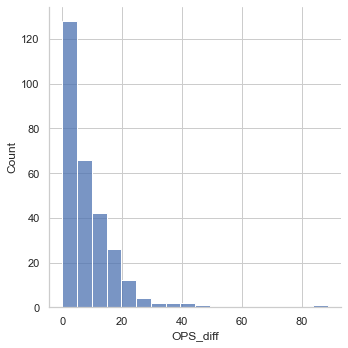

In [125]:
sns.displot(zips_compare['OPS_diff'],bins=18)

The function used for comparison creates a dataframe of statistics compared and populates the percent difference between our projection and another projection system. Looking at a comparison to ZiPs half of our data is within about 5% to 15% difference depending on the feature.

### Streamer

In [126]:
stream_compare = comp_data(stream_df,player_proj_data)

In [127]:
stream_compare = stream_compare[stream_compare.G_diff < 999]

In [128]:
stream_compare.reset_index(inplace=True,drop=True)

In [129]:
stream_compare.head()

,name,G_diff,PA_diff,AB_diff,OBP_diff,SLG_diff,OPS_diff,b_RC_diff,s_RC_diff
0,Mike Trout,11.27,12.01,10.97,1.88,9.17,6.14,0.00,0.78
1,Mookie Betts,2.02,1.47,0.51,1.59,5.52,3.87,7.79,8.47
2,Alex Bregman,1.34,3.39,1.11,1.29,1.54,0.22,0.93,0.92
3,Corey Seager,11.35,12.43,10.62,2.75,3.19,3.01,16.43,16.43
4,Anthony Rendon,5.48,5.97,6.13,5.09,9.03,7.33,7.34,7.34


In [130]:
stream_compare.describe()

,G_diff,PA_diff,AB_diff,OBP_diff,SLG_diff,OPS_diff,b_RC_diff,s_RC_diff
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,71.594047,69.126689,68.989565,6.989632,9.911839,8.436722,72.697057,72.778495
std,77.039872,75.114694,75.095405,8.288629,10.437953,9.071140,76.768247,76.761398
min,0.000000,0.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.900000,9.250000,9.205000,1.880000,2.970000,2.675000,10.070000,9.740000
50%,28.850000,28.570000,28.400000,4.750000,6.950000,5.910000,29.920000,29.920000
75%,139.185000,132.115000,132.200000,8.720000,13.585000,11.660000,137.500000,140.285000
max,200.000000,199.330000,199.230000,77.540000,85.830000,81.710000,200.000000,200.000000


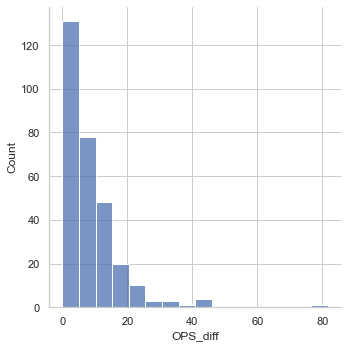

In [131]:
sns.displot(stream_compare['OPS_diff'],bins=16)

Comparing our data to Streamer, we can see half of our data falls between 6% and 30% difference depending on the feature.

### ATC

In [132]:
atc_compare = comp_data(atc_df,player_proj_data)

In [133]:
atc_compare = atc_compare[atc_compare.G_diff < 999]

In [134]:
atc_compare.reset_index(inplace=True,drop=True)

In [135]:
atc_compare.head()

,name,G_diff,PA_diff,AB_diff,OBP_diff,SLG_diff,OPS_diff,b_RC_diff,s_RC_diff
0,Mike Trout,10.60,9.60,10.59,3.07,4.07,3.66,3.12,1.55
1,Freddie Freeman,0.00,0.15,0.18,2.96,4.32,3.75,7.94,7.94
2,Christian Yelich,0.00,0.00,0.91,0.52,0.00,0.22,0.90,2.64
3,Bryce Harper,2.65,2.45,2.45,1.02,1.53,0.55,2.76,1.82
4,Mookie Betts,1.35,0.89,1.03,0.79,0.56,0.65,2.53,3.31


In [136]:
atc_compare.describe()

,G_diff,PA_diff,AB_diff,OBP_diff,SLG_diff,OPS_diff,b_RC_diff,s_RC_diff
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
mean,36.493294,35.400235,35.385412,6.128980,8.422588,7.219333,40.071843,40.013765
std,45.805700,45.500582,45.247694,6.870587,9.233108,7.786748,48.722772,48.663473
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.560000,5.065000,5.270000,1.970000,2.590000,2.270000,6.690000,6.900000
50%,14.060000,13.580000,13.840000,4.070000,5.300000,4.650000,18.180000,17.690000
75%,49.885000,45.485000,47.075000,7.595000,11.030000,9.495000,56.125000,55.870000
max,170.150000,168.590000,168.990000,46.980000,65.230000,54.370000,181.400000,178.180000


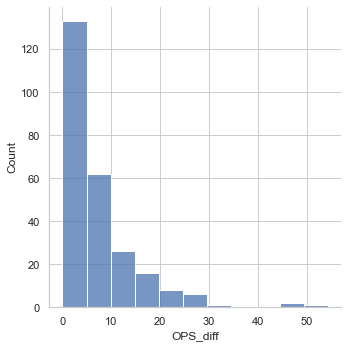

In [137]:
sns.displot(atc_compare['OPS_diff'],bins=11)

Finally, we compare our projections to ATC and find that 50% of our data falls between 4% and 18% difference depending on the feature.

## Conclusion

We have created a projection system that provides predictions of a players batting performance and run creation for the 2021 season. Our testing compared ZiPs, Streamer, and the ATC Projection Systems datasets downloaded from FanGraphs to our own projections. We found that our predictions are quite close to that of ZiPs when sampling players with at least 4 seasons to evaluate, however, this does not necessarily reflect the total accuracy of our method rather only demonstrates our methods potential.

Discrepancies found between our method and that of ZiPs, and any other system, are due to the use of age adjustments and weighted averages. While the point of this notebook was not to recreate ZiPs or any other projection system we can say that our use of estimations and Linear Regression have provided a valid method of projecting a players potential statistics and providing insightful evaluations. I think its worth noting that any difference between our calculations and other projection systems does not completely invalidate our predictions. Any difference measured suggests that if we where to include weighted averages and apply age adjustments along with live game data, we could create projections and evaluations just as accurate (or more accurate) as any other system.